In [25]:
import numpy as np
import pandas as pd
import re
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from scipy import stats as sts

from sklearn.datasets import load_files

nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

from pylab import *
import scipy.optimize as opt

from nltk.stem import PorterStemmer 

ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /Users/sini-
[nltk_data]     sofiakorkeakangas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Pre-processing

In [2]:
# Eetun funktiot

def tokenizer(words):
    # https://gist.github.com/ajnelson-nist/f93e07fca60d0fb42c5c
    tokens_with_count = Counter(map(str.lower, book_words))
    return tokens_with_count

def token_counter(tokens_with_count):
    tokens = sorted([k for k in tokens_with_count.keys()])
    counts = np.array([tokens_with_count[k] for k in tokens])
    ranks = np.arange(1, len(counts) + 1)
    indices = np.argsort(-counts)
    frequencies = counts[indices]
    return ranks, indices, frequencies

def sw_filter(book_words):
    stop_words = stopwords.words('english')
    stop_words.append('The')
    filtered_words = [w.lower() for w in book_words if not w.lower() in stop_words]
    ftokens_with_count = Counter(map(str.lower, filtered_words))
    topwords = [t[0] for t in ftokens_with_count.most_common(20)]
    doclen = len(ftokens_with_count)
    return filtered_words, ftokens_with_count, topwords, doclen

In [3]:
files = ["flatland.txt", "panama-canal.txt", "ulysses.txt"]
books = []

for f in files:
    file = open(f, "r", encoding='utf-8')
    b = re.findall(r'(\b[A-Za-z][a-z]{2,15}\b)', file.read())
    books.append(b)
    file.close()

tcounts = [] # bag of words
tokens = []
counts = []
for b in books:
    words, tcs, _, _ = sw_filter(b)
    tokens.append(list(tcs.keys()))
    counts.append(list(tcs.values()))
    tcounts.append(tcs)

ranks = []
freqs = []
indices = []
for tc in tcounts:
    r, i, f = token_counter(tc)
    ranks.append(r)
    freqs.append(f)
    indices.append(i)
    
for i in range(len(books)):
    books[i] = " ".join(books[i]).lower()

In [4]:
books = pd.DataFrame({'book_name': ["flatland", "panama-canal", "ulysses"], 
                      'book_text': books, 'ranks': ranks, 'freqs': freqs, 
                      'tokens': tokens, 'counts': counts})
books = books.set_index("book_name")

In [5]:
# Book token stemming

tokens_stem = []
for b in books.index:
    t_stem = []
    for w in books.loc[b, "tokens"]:
        t_stem.append(ps.stem(w))
    
    tokens_stem.append(t_stem)
    
books["tokens_stem"] = tokens_stem

books.head()

,book_text,ranks,freqs,tokens,counts,tokens_stem
book_name,,,,,,
flatland,flatland edwin abbott the inhabitance and this...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[155, 113, 105, 95, 82, 77, 77, 76, 75, 73, 62...","[flatland, edwin, abbott, inhabitance, work, d...","[82, 1, 1, 1, 4, 1, 7, 4, 9, 73, 1, 9, 4, 1, 2...","[flatland, edwin, abbott, inhabit, work, dedic..."
panama-canal,produced steven gibbs barbara kosker and the o...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[606, 401, 285, 269, 210, 171, 162, 140, 136, ...","[produced, steven, gibbs, barbara, kosker, onl...","[12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 10, 2...","[produc, steven, gibb, barbara, kosker, onlin,..."
ulysses,produced david widger complete grant man propo...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1524, 1278, 1213, 1110, 1047, 871, 840, 836, ...","[produced, david, widger, complete, grant, man...","[11, 3, 1, 47, 53, 182, 2, 5, 1, 90, 28, 38, 7...","[produc, david, widger, complet, grant, man, p..."


# Task 7.

We would like to test the **Zipf’s law on word categories** instead of the whole set of words. For this purpose, **using the topic of the ebook content, suggest appropriate identification of LIWC category(ies)**; for instance, horror like ebook would entail Psychological process like categories. 

You should notice that LIWC full list of wording is not freely available, so you may use alternatives provided in the lecture handout or suggest your own alternative.

Once appropriate category is found, you should **only construct the frequency graph with respect to words of that category**, and then try to fit the Zipf’s curve distribution. 

If more than one category is found to match the ebook content, **select the category that contains the higher number of words**. Devise appropriate high level description of your implementation -how this has been achieved.


- LIWC alternative categories: http://www.wjh.harvard.edu/~inquirer/homecat.htm


TO-DO:
1. **Discover relevant categories** for each book, ie. categories from General Inquirer
    - How many categories?
    - Clustering to propose categories?
    
2. **Collect words belonging to each category**, e.g. by crawling the web (wikipedia might be enough)
    
3. Select **most frequent words** for words crawled for each category and exclude stopwords -> related words to each category


### Discover relevant categories

Descriptions for each book:

- Ulysses: https://en.wikipedia.org/wiki/Personal_Memoirs_of_U._S._Grant
- Flatland: https://en.wikipedia.org/wiki/Flatland
- Panama Canal: https://www.amazon.com/Panama-Canal-History-Description-Enterprise/dp/1296899330

GI categories: http://www.wjh.harvard.edu/~inquirer/homecat.htm

#### Flatland
- Mathematics / geometry / space
- Relationships
- Feelings
    - GI: Pleasur (168 words), Feel (49 words)
- Gender
    - GI: MALE (56 words), Female (43 words)

#### Ulysses
- Military 
    - GI: Milit (88 words), 
- Politics / Legal
    - GI: Legal (192 words), POLIT (507 words), Econ@ (510 words)

#### Panama Canal
- Industrial
    - GI: Work (261 words), Econ@ (510 words)
- Economics (?)
    - GI: Econ@ (510 words)

In [7]:
cat = pd.read_excel("inquirerbasic.xls")

# Drop semantic categories
cat = cat.drop(columns=['Source', 'Positiv', 'Negativ', 'Pstv', 'Ngtv', 'Affil',
                 'Hostile', 'Strong', 'Power', 'Weak', 'Submit', 'Active', 'Passive',
                 'Pleasur', 'Pain', 'Feel', 'Arousal', 'EMOT', 'Virtue', 'Vice',
                 'Ovrst', 'Undrst'])

# Drop otherwise redundant categories
cat = cat.drop(columns=['ComForm', 'COM', 'Say', 'Need', 'Goal', 'Try', 'Means', 'MeansLw',
                       'Persist', 'Complet', 'Finish', 'Fail',])

# Lowercase
cat.Entry = cat.Entry.str.lower()

# Remove numbers and certain special characters
cat.Entry = cat.Entry.replace(to_replace=r'#|[0-9]|_', value="", regex=True)

# Dummy encoding
for c in cat.columns:
    if len(pd.unique(cat[c])) == 2:
        cat[c] = [(1 if val == c else 0) for val in cat[c]]

In [8]:
cat.head()

,Entry,Academ,Doctrin,Econ@,Exch,ECON,Exprsv,Legal,Milit,Polit@,...,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw,Othtags,Defined
0,a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,DET ART,| article: Indefinite singular article--some o...
1,abandon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SUPV,|
2,abandonment,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Noun,|
3,abate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SUPV,|
4,abatement,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Noun,NaN


### Categorisation

- (Crawling if GI data not enough)
- Stemming

In [85]:
def categoriseGI(cat_columns=[cat.Academ, cat.Milit, cat.Work], cat_names=["Academ", "Milit", "Work"]):
    """
    cat_columns: List of categories (max length 3) in the order flatland, ulysses, panama-canal
    cat_names: List of category names as strings (max length 3)
    """
    cat_words = {'flatland': list(cat.loc[cat_columns[0] == 1, "Entry"].unique()),
                 'ulysses': list(cat.loc[cat_columns[1] == 1, "Entry"].unique()),
                 'panama-canal': list(cat.loc[cat_columns[2] == 1, "Entry"].unique())}
    cat_names = {'flatland': cat_names[0], 'ulysses': cat_names[1], 'panama-canal': cat_names[2]}
    
    # Initialize stemmed words, matching words, ranks and freqs
    cat_stem = {'flatland': [], 'ulysses': [], 'panama-canal': []}
    cat_match = {'flatland': [], 'ulysses': [], 'panama-canal': []}
    cat_freqs = {'flatland': [], 'ulysses': [], 'panama-canal': []}
    cat_ranks = {'flatland': [], 'ulysses': [], 'panama-canal': []}
    
    # Stemming for category words
    for b in books.index:
        for w in cat_words[b]:
            cat_stem[b].append(ps.stem(w))
    
    # Match categories
    for b in books.index:
        for i in range(len(books.loc[b, "tokens_stem"])):
            if books.loc[b, "tokens_stem"][i] in cat_stem[b]:
                cat_match[b].append(books.loc[b, "tokens"][i])
                cat_freqs[b].append(books.loc[b, "freqs"][i])
                cat_ranks[b].append(books.loc[b, "ranks"][i])
    
    return cat_words, cat_names, cat_stem, cat_match, cat_freqs, cat_ranks

In [96]:
cat_words, cat_names, cat_stem, cat_match, cat_freqs, cat_ranks = categoriseGI(cat_columns=[cat.Academ, cat.Milit, cat.loc[:,"Econ@"]], cat_names=["Academ", "Milit", "Econ@"])

Number of matches:

In [107]:
for b in ["panama-canal", "ulysses"]: 
    print(b)
    print(len(cat_freqs[b]))
    print("----")

panama-canal
460
----
ulysses
134
----


50 most frequent words for each book's category:

In [97]:
n = 20

for b in books.index:
    print(b + ":")
    print("-----------------")
    print(", ".join(cat_match[b][0:n-1]) + "\n")

flatland:
-----------------
universe, experiences, word, course, learned, knowledge, intelligible, theory, form, universally, degrees, intelligent, intellectual, intellect, examination, board, wisdom, wise, intelligence

panama-canal:
-----------------
produced, engineer, mine, report, tolls, trade, commerce, useful, valuable, interesting, secretary, department, bank, grant, control, reports, company, bankruptcy, occupation

ulysses:
-----------------
general, rebellion, regimental, troops, commanders, generations, generation, army, war, battles, battle, soldiers, marching, service, private, mine, soldier, generally, regiment



### Results

In [90]:
def ahat(n, rank):
    return 1 + ( n / sum(log(rank / min(rank) - 0.5) ))

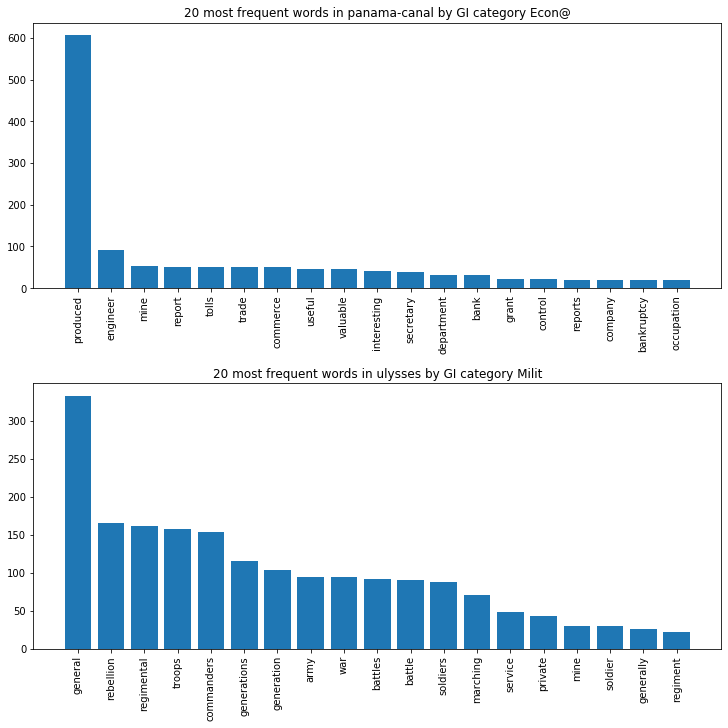

In [109]:
n = 20

# Histograms
fig, axs = plt.subplots(2, figsize=(10,10), constrained_layout=True)
i = 0

for b in ["panama-canal", "ulysses"]:
    axs[i].set_title("20 most frequent words in " + b + " by GI category " + cat_names[b])
    axs[i].bar(cat_match[b][0:n-1], cat_freqs[b][0:n-1])
    axs[i].set_xticklabels(cat_match[b][0:n-1], rotation='vertical')

    i = i+1
plt.show()

In [99]:
def zipf_f(x, a):
    return x**(-a)

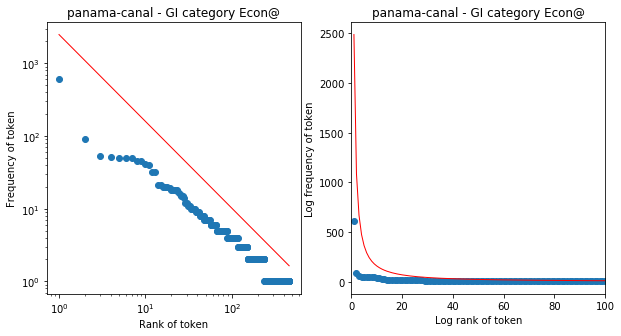

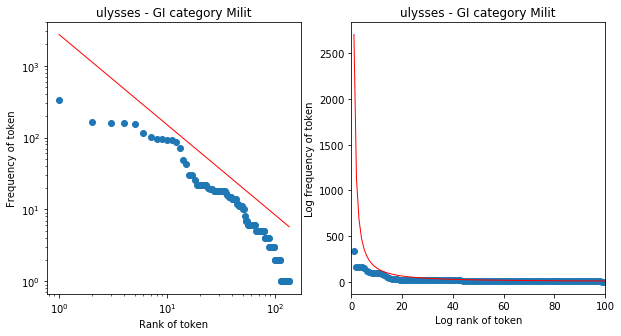

In [119]:
# Fitted Zipf

i = 0
for b in ["panama-canal", "ulysses"]:
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    
    ranks = np.arange(1, len(cat_freqs[b])+1)
    
    a = ahat(len(ranks), ranks)
    p = zipf_f(ranks, a)
    
    total = sum(np.array(cat_freqs[b]))
    
    # Loglog
    axs[0].scatter(ranks, cat_freqs[b])
    axs[0].loglog(ranks, p*total, lw=1, color="red")
    
    axs[0].set_title(b + " - GI category " + cat_names[b])
    axs[0].set_ylabel("Frequency of token")
    axs[0].set_xlabel("Rank of token")
    
    # Linear
    axs[1].scatter(ranks, cat_freqs[b])
    axs[1].plot(ranks, p*total, lw=1, color="red")
    
    axs[1].set_title(b + " - GI category " + cat_names[b])
    axs[1].set_ylabel("Log frequency of token")
    axs[1].set_xlabel("Log rank of token")
    axs[1].set_xlim(0, 100)
    
    plt.show()
